In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter

In [ ]:
transform = transforms.Compose(
[transforms.ToTensor(),transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
trainset = torchvision.datasets.CIFAR10(root='./data',train=True,download=True,transform=transform)
trainloader = torch.utils.data.DataLoader(trainset,batch_size=4,shuffle=True,num_workers=0)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=0)
testset = torchvision.datasets.CIFAR10(root='./data',train=False,download=False,transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,shuffle=False,num_workers=0)
classes = ('plane','car','bird','cat','deer','dog','frog','horse','ship','truck')

44.6%

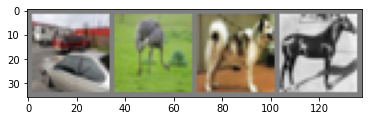

  car  bird   dog horse


In [3]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
# 显示图像
def imshow(img):
    img = img / 2 + 0.5  #unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.show()

# 随机获取部分训练数据
dataiter = iter(trainloader)
images, labels = dataiter.next()

# 显示图像
imshow(torchvision.utils.make_grid(images))
# 打印标签
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [4]:
import torch.nn as nn
import torch.nn.functional as F
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        
class CNNNet(nn.Module):
    def __init__(self):
        super(CNNNet,self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=36, kernel_size=3,stride=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.fc1 = nn.Linear(1296,128)
        self.fc2 = nn.Linear(128,10)

    def forward(self,x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        #print(x.shape)
        x=x.view(-1,36*6*6)
        x=F.relu(self.fc2(F.relu(self.fc1(x))))
        return x
net = CNNNet()
net=net.to(device)

In [5]:
import torch.optim as optim
LR=0.001

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=LR, momentum=0.9)

In [6]:
#初始化数据
for m in net.modules():
    if isinstance(m,nn.Conv2d):
        nn.init.normal_(m.weight)
        nn.init.xavier_normal_(m.weight)
        nn.init.kaiming_normal_(m.weight)#卷积层参数初始化
        nn.init.constant_(m.bias, 0)
    elif isinstance(m,nn.Linear):
        nn.init.normal_(m.weight)#全连接层参数初始化
        

In [7]:
#训练模型
for epoch in range(2):  

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # 获取训练数据
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # 权重参数梯度清零
        optimizer.zero_grad()

        # 正向及反向传播
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 显示损失值
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 5.123
[1,  4000] loss: 2.303
[1,  6000] loss: 2.303
[1,  8000] loss: 2.303
[1, 10000] loss: 2.303
[1, 12000] loss: 2.303
[2,  2000] loss: 2.303
[2,  4000] loss: 2.303
[2,  6000] loss: 2.303
[2,  8000] loss: 2.303
[2, 10000] loss: 2.303
[2, 12000] loss: 2.303
Finished Training


In [8]:
import torchvision.utils as vutils
writer = SummaryWriter(log_dir='logs',comment='feature map')

In [34]:
for i, data in enumerate(trainloader, 0):
        # 获取训练数据
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        x=inputs[0].unsqueeze(0)
        print(x.shape)
        break


torch.Size([1, 3, 32, 32])


In [35]:
img_grid = vutils.make_grid(x, normalize=True, scale_each=True, nrow=8)
writer.add_image('yun', img_grid, global_step=1)
net.eval()
for name, layer in net._modules.items():

    # 为fc层预处理x
    x = x.view(x.size(0), -1) if "fc" in name else x
    print(x.size())

    x = layer(x)
    print(f'{name}')

    # 查看卷积层的特征图
    if  'layer' in name or 'conv' in name:
        x1 = x.transpose(0, 1)  # C，B, H, W  ---> B，C, H, W
        img_grid = vutils.make_grid(x1, normalize=True, scale_each=True, nrow=4)  # normalize进行归一化处理
        writer.add_image(f'{name}_feature_maps', img_grid, global_step=0)
writer.close()

torch.Size([1, 3, 32, 32])
conv1
torch.Size([1, 16, 28, 28])
pool1
torch.Size([1, 16, 14, 14])
conv2
torch.Size([1, 36, 12, 12])
pool2
torch.Size([1, 1296])
fc1
torch.Size([1, 128])
fc2
